# Predicting Time Series With LSTMs

Traditional neural networks like myself suffer from catestrophic forgetfullness. For problems such as time series or NLP, it is not good enough to make a prediction based on inputs in iscolation. A prediction needs to be made given the context of the element in the sequence.

In [24]:
import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
class DataLoader:
    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_train_data(self, seq_len, normalise):
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)
    
    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y
    
    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y
    
    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)


In [26]:
class Model:
    def __init__(self):
        self.model = Sequential()

    def build_model(self, configs):
        for layer in configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

        print('[Model] Model Compiled')
        
        
    def train(self, x, y, epochs, batch_size, save_dir):
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

        save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]
        self.model.fit(
            x,
            y,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        self.model.save(save_fname)

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        

    def predict_point_by_point(self, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequence_full(self, data, window_size):
        #Shift the window by 1 new prediction each time, re-run predictions on new window
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        return predicted

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [27]:
configs = {
    "data": {
        "filename": "sp500.csv",
        "columns": [
            "Close",
            "Volume"
        ],
        "sequence_length": 50,
        "train_test_split": 0.85,
        "normalise": True
    },
    "training": {
        "epochs": 1,
        "batch_size": 32
    },
    "model": {
        "loss": "mse",
        "optimizer": "adam",
        "layers": [
            {
                "type": "lstm",
                "neurons": 100,
                "input_timesteps": 49,
                "input_dim": 2,
                "return_seq": True
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type": "lstm",
                "neurons": 100,
                "return_seq": True
            },
            {
                "type": "lstm",
                "neurons": 100,
                "return_seq": False
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type": "dense",
                "neurons": 1,
                "activation": "linear"
            }
        ]
    }
}

In [29]:
# configs = json.load(open('config.json', 'r'))
filename = "https://raw.githubusercontent.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/master/data/sp500.csv"
data = DataLoader(
    filename,
    configs['data']['train_test_split'],
    configs['data']['columns']
)

model = Model()
model.build_model(configs)
x, y = data.get_train_data(
    seq_len = configs['data']['sequence_length'],
    normalise = configs['data']['normalise']
)

model.train(
    x,
    y,
    epochs = configs['training']['epochs'],
    batch_size = configs['training']['batch_size'],
    save_dir="models"
)

x_test, y_test = data.get_test_data(
    seq_len = configs['data']['sequence_length'],
    normalise = configs['data']['normalise']
)

[Model] Model Compiled
[Model] Training Started
[Model] 1 epochs, 32 batch size
Epoch 1/1
3942/3942 [==============================] - 32s 8ms/step - loss: 9.9183e-04


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


[Model] Training Completed. Model saved as models/11122019-075651-e1.h5


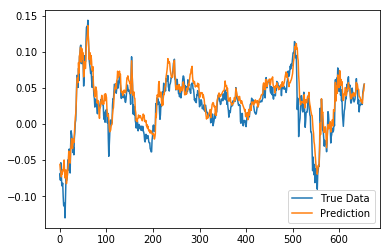

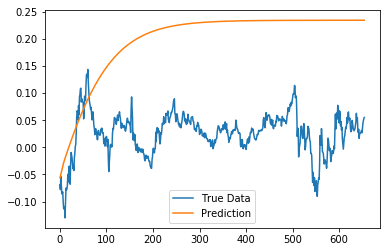

In [30]:
predictions_pointbypoint = model.predict_point_by_point(x_test)
plot_results(predictions_pointbypoint, y_test)

predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
plot_results(predictions_fullseq, y_test)
plt.show()